Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch: 0001 cost = 0.701546348
Epoch: 0002 cost = 0.231422036
Epoch: 0003 cost = 0.167427033
Epoch: 0004 cost = 0.134825501
Epoch: 0005 cost = 0.111704997
Epoch: 0006 cost = 0.101142280
Epoch: 0007 cost = 0.085034508
Epoch: 0008 cost = 0.080768319
Epoch: 0009 cost = 0.068649759
Epoch: 0010 cost = 0.064436887
Epoch: 0011 cost = 0.056208443
Epoch: 0012 cost = 0.052251488
Epoch: 0013 cost = 0.049863316
Epoch: 0014 cost = 0.048229224
Epoch: 0015 cost = 0.042993041
Epoch: 0016 cost = 0.041112586
Epoch: 0017 cost = 0.036705013
Epoch: 0018 cost = 0.037128726
Epoch: 0019 cost = 0.034930416
Epoch: 0020 cost = 0.032686845
Learning Finished!
Accuracy: 0.9832
Label:  [0]
Prediction:  [0]


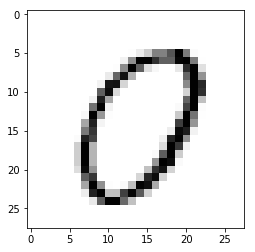

In [47]:
# sigmoid->relu
#Gradient->Adam
#random->Xavier
#dropout
# Lab 7 Learning rate and Evaluation
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import math
from tensorflow.examples.tutorials.mnist 
import input_data

tf.set_random_seed(777)  # reproducibility
tf.reset_default_graph()
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

def xavier_init(n_inputs, n_outputs, uniform=True):
  if uniform:
    # 6 was used in the paper.
    init_range = math.sqrt(6.0 / (n_inputs + n_outputs))
    return tf.random_uniform_initializer(-init_range, init_range)
  else:
    # 3 gives us approximately the same limits as above since this repicks
    # values greater than 2 standard deviations from the mean.
    stddev = math.sqrt(3.0 / (n_inputs + n_outputs))
    return tf.truncated_normal_initializer(stddev=stddev)


learning_rate = 0.0007
training_epochs = 15
batch_size = 100
total_batch = int(mnist.train.num_examples / batch_size)
keep_prob = tf.placeholder(tf.float32)


# MNIST data image of shape 28 * 28 = 784
X = tf.placeholder(tf.float32, [None, 784])
# 0 - 9 digits recognition = 10 classes
Y = tf.placeholder(tf.float32, [None, 10])

dropout_rate = tf.placeholder("float")

W1 = tf.get_variable("W1", shape=[784, 512], initializer=xavier_init(784, 512))
W2 = tf.get_variable("W2", shape=[512, 400], initializer=xavier_init(512, 400))
W3 = tf.get_variable("W3", shape=[400, 256], initializer=xavier_init(400, 256))
W4 = tf.get_variable("W4", shape=[256, 256], initializer=xavier_init(256, 256))
W5 = tf.get_variable("W5", shape=[256, 10], initializer=xavier_init(256, 10))

B1 = tf.Variable(tf.random_normal([512]))
B2 = tf.Variable(tf.random_normal([400]))
B3 = tf.Variable(tf.random_normal([256]))
B4 = tf.Variable(tf.random_normal([256]))
B5 = tf.Variable(tf.random_normal([10]))

# Construct model
_L1 = tf.nn.relu(tf.add(tf.matmul(X,W1),B1))
L1 = tf.nn.dropout(_L1, dropout_rate)
_L2 = tf.nn.relu(tf.add(tf.matmul(L1, W2),B2)) # Hidden layer with ReLU activation
L2 = tf.nn.dropout(_L2, dropout_rate)
_L3 = tf.nn.relu(tf.add(tf.matmul(L2, W3),B3)) # Hidden layer with ReLU activation
L3 = tf.nn.dropout(_L3, dropout_rate)
_L4 = tf.nn.relu(tf.add(tf.matmul(L3, W4),B4)) # Hidden layer with ReLU activation
L4 = tf.nn.dropout(_L4, dropout_rate)

hypothesis = tf.add(tf.matmul(L4, W5), B5)


cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
   logits=hypothesis, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)



sess = tf.Session()
sess.run(tf.global_variables_initializer())
    
for epoch in range(training_epochs):
    avg_cost = 0

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys, dropout_rate: 0.7}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:',accuracy.eval(session=sess, feed_dict={X: mnist.test.images, Y: mnist.test.labels, dropout_rate: 1}))

# Get one and predict
r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction: ", sess.run(tf.argmax(hypothesis, 1), feed_dict={X: mnist.test.images[r:r + 1], dropout_rate: 1}))

plt.imshow(mnist.test.images[r:r + 1].reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()



In [48]:
# Lab 13 Tensorboard
import tensorflow as tf
import random

from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777)  # reproducibility

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

# parameters
learning_rate = 0.0008
training_epochs = 15
batch_size = 100

TB_SUMMARY_DIR = './tb/mnist'

# input place holders
X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])

# Image input
x_image = tf.reshape(X, [-1, 28, 28, 1])
tf.summary.image('input', x_image, 3)

# dropout (keep_prob) rate  0.7~0.5 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

# weights & bias for nn layers
# http://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
with tf.variable_scope('layer1') as scope:
    W1 = tf.get_variable("W", shape=[784, 512],
                         initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.Variable(tf.random_normal([512]))
    L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
    L1 = tf.nn.dropout(L1, keep_prob=keep_prob)

    tf.summary.histogram("X", X)
    tf.summary.histogram("weights", W1)
    tf.summary.histogram("bias", b1)
    tf.summary.histogram("layer", L1)

with tf.variable_scope('layer2') as scope:
    W2 = tf.get_variable("W", shape=[512, 512],
                         initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.Variable(tf.random_normal([512]))
    L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
    L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

    tf.summary.histogram("weights", W2)
    tf.summary.histogram("bias", b2)
    tf.summary.histogram("layer", L2)

with tf.variable_scope('layer3') as scope:
    W3 = tf.get_variable("W", shape=[512, 512],
                         initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.Variable(tf.random_normal([512]))
    L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
    L3 = tf.nn.dropout(L3, keep_prob=keep_prob)

    tf.summary.histogram("weights", W3)
    tf.summary.histogram("bias", b3)
    tf.summary.histogram("layer", L3)

with tf.variable_scope('layer4') as scope:
    W4 = tf.get_variable("W", shape=[512, 512],
                         initializer=tf.contrib.layers.xavier_initializer())
    b4 = tf.Variable(tf.random_normal([512]))
    L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
    L4 = tf.nn.dropout(L4, keep_prob=keep_prob)

    tf.summary.histogram("weights", W4)
    tf.summary.histogram("bias", b4)
    tf.summary.histogram("layer", L4)

with tf.variable_scope('layer5') as scope:
    W5 = tf.get_variable("W", shape=[512, 10],
                         initializer=tf.contrib.layers.xavier_initializer())
    b5 = tf.Variable(tf.random_normal([10]))
    hypothesis = tf.matmul(L4, W5) + b5

    tf.summary.histogram("weights", W5)
    tf.summary.histogram("bias", b5)
    tf.summary.histogram("hypothesis", hypothesis)


# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=hypothesis, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

tf.summary.scalar("loss", cost)

# Summary
summary = tf.summary.merge_all()

# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Create summary writer
writer = tf.summary.FileWriter(TB_SUMMARY_DIR)
writer.add_graph(sess.graph)
global_step = 0

print('Start learning!')

# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7}
        s, _ = sess.run([summary, optimizer], feed_dict=feed_dict)
        writer.add_summary(s, global_step=global_step)
        global_step += 1

        avg_cost += sess.run(cost, feed_dict=feed_dict) / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={
      X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1}))

# Get one and predict
r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction: ", sess.run(
    tf.argmax(hypothesis, 1), feed_dict={X: mnist.test.images[r:r + 1], keep_prob: 1}))

# plt.imshow(mnist.test.images[r:r + 1].
#           reshape(28, 28), cmap='Greys', interpolation='nearest')
# plt.show()

'''
tensorboard --logdir tb/
Starting TensorBoard b'41' on port 6006
(You can navigate to http://10.0.1.4:6006)

'''
'''
Epoch: 0001 cost = 0.447322626
Epoch: 0002 cost = 0.157285590
Epoch: 0003 cost = 0.121884535
Epoch: 0004 cost = 0.098128681
Epoch: 0005 cost = 0.082901778
Epoch: 0006 cost = 0.075337573
Epoch: 0007 cost = 0.069752543
Epoch: 0008 cost = 0.060884363
Epoch: 0009 cost = 0.055276413
Epoch: 0010 cost = 0.054631256
Epoch: 0011 cost = 0.049675195
Epoch: 0012 cost = 0.049125314
Epoch: 0013 cost = 0.047231930
Epoch: 0014 cost = 0.041290121
Epoch: 0015 cost = 0.043621063
Learning Finished!
Accuracy: 0.9804
'''


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Start learning!
Epoch: 0001 cost = 0.445616285
Epoch: 0002 cost = 0.159595469
Epoch: 0003 cost = 0.118979728


KeyboardInterrupt: 